In [2]:
# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
from scipy import interpolate
import scipy as sp
from scipy.optimize import curve_fit
import datetime

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

(0.0, 10.0)

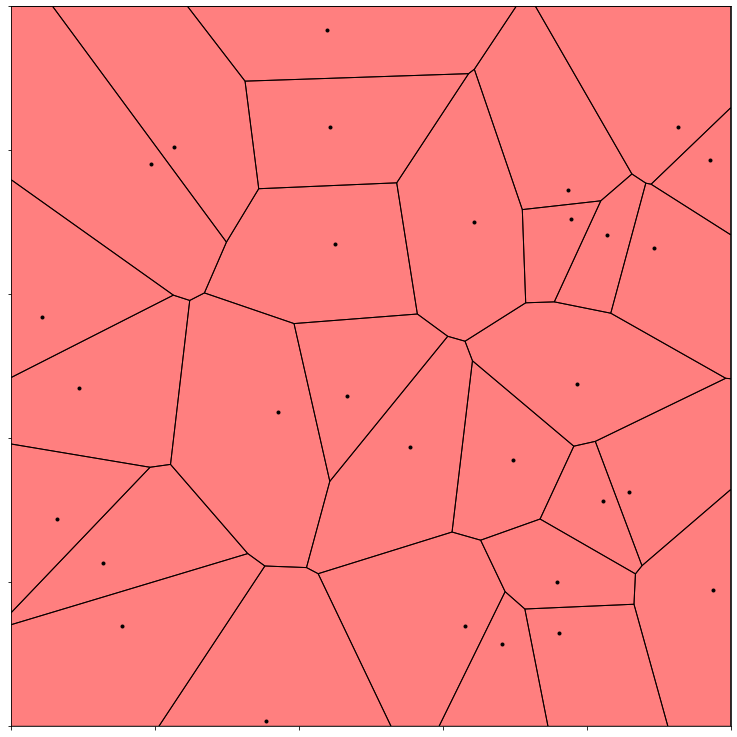

In [16]:
# first set up random collection of "center points"
N = 30 # number of points
xmax = 10 # x-width of area
ymax = 10 # y-width of area
RNG_seed = 42

diagnostics = False

xrange = np.linspace(0,10,num=2)

# generate random lists of x and y-coordinates by sampling from uniform distribution
rng = np.random.default_rng(seed=RNG_seed)
x = rng.uniform(0,xmax,N)
y = rng.uniform(0,ymax,N)

# plot points
fig = plt.figure(figsize=[10,10])
ax = fig.add_axes([0,0,1,1])

for ii in range(N):
    ax.plot(x[ii],y[ii],marker='o',markersize=3,color='xkcd:black')
    
ax.set_xticklabels([])
ax.set_yticklabels([])

# cell construction
for ii in range(N):
    
    if diagnostics:
        ax.plot(x[ii],y[ii],marker='o',markersize=6,color='xkcd:red')
    
    # make a list of nearest neighbors
    distance_list = []
    
    # first calculate distances from neighbors to primary points
    for jj in range(N):
        distance_list.append(np.sqrt((x[jj] - x[ii])**2 + (y[jj] - y[ii])**2))
    
    # now sort the distances in ascending order and make note of the corresponding indices
    distances = zip(range(N),distance_list)
    distances = sorted(distances, key=lambda t: t[1])
    NN_idx, NN_dist = zip(*distances)
    
    # now construct the cell
    jj = 1 # start from index one (index zero represents the point itself)
    dA = 1000
    threshold = 0
    
    # initialize the cell using the boundaries of the entire field
    cell = [(xmax,ymax),
            (0,ymax),
            (0,0),
            (xmax,0),
           ]
    cell.append(cell[0]) # add the original point as the final point so the polygon closes  
    
    # as long as the cell continues to shrink...
    stop = False
    while stop == False:
        
        xj = x[NN_idx[jj]]
        yj = y[NN_idx[jj]]
        
        if diagnostics:
            ax.plot(xj,yj,marker='o',markersize=6,color='xkcd:blue')
        
        # ...draw a line bisecting the primary point and its next nearest neighbor
        mL = -1/((y[ii] - yj)/((x[ii] - xj))) # slope
        bL = (yj + y[ii])/2 - mL*(xj + x[ii])/2 # intercept
        
        if diagnostics:
            ax.plot(xrange,mL*xrange+bL,'k--')
        
        # determine whether and if so, where the line intersects with the cell
        
        new_verts = {} # initialize a dictionary of new vertices
        intersection = False
        for kk in range(len(cell)):
            
            # calculate the slope and intercept of the line between this and the previous vertex of the cell
            # case 1: cell segment vertical
            if cell[kk][0] == cell[kk-1][0]:
                
                # calculate the y-coordinate of the line at the x-value of the segment
                xi = cell[kk][0]
                yL = mL*xi + bL
                
                # if it falls between segment minimum and maximum, it intersects
                if yL <= np.max([cell[kk][1],cell[kk-1][1]]) and yL >= np.min([cell[kk][1],cell[kk-1][1]]):
                    new_verts[kk] = (xi, yL)
                    intersection = True
            # case 2: cell segment non-vertical  
            else:
                mS = (cell[kk][1] - cell[kk-1][1])/(cell[kk][0] - cell[kk-1][0])
                bS = cell[kk][1] - mS*cell[kk][0]

                # calculate the x-coordinate of the point of intersection between the line and the segment
                xi = (bL - bS)/(mS - mL)
            
                # if the intersection falls within the line segment, take note of the point and where it falls in relation 
                # to the original vertices
                if xi <= np.max([cell[kk][0],cell[kk-1][0]]) and xi >= np.min([cell[kk][0],cell[kk-1][0]]):
                    new_verts[kk] = (xi, mS*xi + bS)
                    intersection = True
        
        # if the bisection line passes through the current cell, split it
        if intersection:
            
            # place the new vertices in proper sequence
            new_cell = [] # initialize the new list of vertices
            NV_idxs = []
            idx = 0
            for kk in range(len(cell)):
                # if a new vertex should be put in, do so...
                if kk in new_verts.keys():
                    new_cell.append(new_verts[kk])
                    NV_idxs.append(idx) # keep track of where it went in
                    idx += 1
                # ...then add the original vertex
                new_cell.append(cell[kk])
                idx += 1
            
            # lose the last, redundant entry for the moment 
            new_cell = new_cell[:-1]
            
            # now that we have the new cell, break it up
            new_cell1 = new_cell[NV_idxs[0]:NV_idxs[1]+1]
            new_cell2 = new_cell[NV_idxs[1]:] + new_cell[:NV_idxs[0]+1]
            
            # finally, determine which of the two subcells the original point lies in
            # by drawing a line from the original point to one of the vertices of the original cell;
            # if that line intersects the nearest-neighbor bisecting line, that vertex belongs to the
            # empty new cell. Arbitrarily, we choose the first vertex in the first cell, but any will do 
            # as long as they are not the new vertices used to generate the split (because they trivially
            # lie on the bisecting line):
            mP = (new_cell1[1][1] - y[ii])/(new_cell1[1][0] - x[ii])
            bP = y[ii] - mP*x[ii]
            # calculate the point at which the lines intersect
            xR = (bP - bL)/(mL - mP)
            # if the intersection occurs within the cell, reject it
            if xR <= np.max([new_cell1[0][0],new_cell1[-1][0]]) and xR >= np.min([new_cell1[0][0],new_cell1[-1][0]]) and (xR - x[ii])/(new_cell1[1][0] - x[ii]) > 0:
                cell = new_cell2
            # otherwise, keep it
            else:
                cell = new_cell1
            # add the original point as the final point so the polygon closes    
            cell.append(cell[0])
                
        if diagnostics:
            if jj == 7:

                polygon1 = mpl.patches.Polygon(cell, facecolor=[1,0,0,0.5], edgecolor='k')
                ax.add_patch(polygon1)
                break
            
        # decide when to stop by comparing distances to the cell vertices against the next nearest neighbor distance
        vert_dists = []
        for vertex in cell:
            vert_dists.append(np.sqrt((x[ii] - vertex[0])**2 + (y[ii] - vertex[1])**2))

        if np.max(vert_dists) < 0.5*NN_dist[jj+1]:
            polygon1 = mpl.patches.Polygon(cell, facecolor=[1,0,0,0.5], edgecolor='k')
            ax.add_patch(polygon1)
            stop = True
            
        jj += 1
    
#     if ii == 5: 
#         break

ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])

In [ ]:
new_cell1

In [ ]:
xR

In [ ]:
mP, bP

In [ ]:
np.min([cell[kk][0],cell[kk-1][0]])